In [4]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix, coo_matrix
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, KFold
from scipy.sparse import vstack
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


In [5]:

df = pd.read_csv('../data/UI_matrix_n_5_r.csv')

df = df.set_index('user_id')

df

,--onnLZrsCazmcy2P_7fcw,-3AooxIkg38UyUdlz5oXdw,-8iATYRnN46Km0_-ldx6cg,-9r8nAzWyRSLxBWt8uQOdA,-ALqLSTzkGDMscHdxA1NgA,-BdYhP-12elmFV7oB1iv4A,-FM4CxOg4XXmX_Ebky_SiQ,-FRHYI6doGCjIsXiKHkUqw,-Fka99c-tJ-epWYNIobqyQ,-H-fZonTLitwHFY_PLAIjA,...,zVxDd79gdZcfz-O14QBCrA,zWwGjQlUEiLS7hCXDkBGzg,zYTQOpgMSMaFNkcCAvJR3Q,zZrDoiQIUmiVkifJx0h_KA,zbrIMldF_O1ZQ0vpUaaa8A,zeAfmYy9b1gfUJLRBHm6vQ,ziXR7sUrbKRCNeDqfjibUg,zpuFEeAhrNzXPkOlBf5Kog,zu4p6IZLSVn2Noto-vcwzw,zxW8zECvT_SqejieMMjb5A
user_id,,,,,,,,,,,,,,,,,,,,,
-0-TtVhV4PIUoDpUCOC0uQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0EcgtUXe1rzrkmdih_tYg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1-ECBsGpG4Iw5s-ecnfqw,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-14MA777BbjUQLw0zndvfA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1WbN1Qd-opw8u3uEqs2Kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuPjUmHmYz1TIiamDjgJgg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zv6CI7HvLGRHgu6yqX-Asw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zvs6DYpACuh0cpsPDO48dw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## looking at matrix sparsity

In [3]:
df = pd.read_csv('../data/UI_matrix_n_5_r.csv')

df = df.set_index('user_id')


# Count the number of non-NaN interactions/items for each user
interactions_per_user = df.count(axis=1)

# Check how many users have fewer than 10 interactions
users_below_threshold = interactions_per_user[interactions_per_user < 5].count()

print(users_below_threshold)


#matrix sparsity check
nan_count= df.isna().sum().sum()

total_entries = df.size

sparsity_percentage = (nan_count / total_entries) * 100

print(f"sparsity of matrix is {sparsity_percentage}%")



0
sparsity of matrix is 99.07191017254513%


# Creating a mapping for user id's 

In [6]:
user_index_to_id = {index: user_id for index, user_id in enumerate(df.index)}
user_id_to_index = {user_id: index for index, user_id in user_index_to_id.items()}

#user_index_to_id[0] would return the first user id
#user_id_to_index["-1-ECBsGpG4Iw5s-ecnfqw"] would return 0

item_index_to_id = {index: business_id for index, business_id in enumerate(df.columns)}
item_id_to_index = {business_id: index for index, business_id in item_index_to_id.items()}

df.rename(columns=item_id_to_index, inplace=True)



# Train test split - removing 20 percent of reviews from each usuer

In [5]:
#this takes 10.5 minutes to run so I write the dataframes to a file

def train_test_split(df, test_size=0.2):
    # Make a copy of the original set to be the test set. 
    test_df = df.copy()
    
    # Make another copy to store the training data.
    train_df = df.copy()
    
    # For each user (index) go through the data on that row (resturaunts)
    for index, row in df.iterrows():
        # Find indices of non-NaN values in the current row
        non_na_indices = row.dropna().index

        # Randomly sample from these indices
        test_indices = np.random.choice(non_na_indices, size=int(len(non_na_indices) * test_size), replace=False)
        
        # Set these as NaN in the training set. Index represents the current 
        train_df.loc[index, test_indices] = np.nan

        # Set all other values (those not in test_indices) as NaN in the test set
        test_df.loc[index, df.columns[~df.columns.isin(test_indices)]] = np.nan

    return train_df, test_df

# Splitting the DataFrame
train_df, test_df = train_test_split(df, test_size=0.2)


In [26]:

train_df.to_csv('../data/train_data_n5_r.csv',index=False)
test_df.to_csv('../data/test_data_n5_r.csv',index=False)

In [7]:
train_data = pd.read_csv('../data/train_data_n5_r.csv')

test_data  = pd.read_csv('../data/test_data_n5_r.csv')


train_non_na = train_data.notnull()
test_non_na = test_data.notnull()

# Check for overlaps: Both matrices have non-NaN at the same position
overlap = (train_non_na & test_non_na).sum().sum()

print(overlap)


0


# Stochastic Gradient Descent (SGD) for matrix factorization


In [8]:
# Replace NaN values with zeros
train_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)


#creating a sparse representation of training / testing data
train_data_sparse = coo_matrix(train_data.to_numpy())

test_data_sparse = coo_matrix(test_data.to_numpy())


# Matrix factorization using a sparse representation

In [9]:
# R - user item matrix, k - # of latent features, alpha - learning rate, beta - regularization parameter

def matrix_factorization_SGD(R, K, alpha, beta, iterations):

    np.random.seed(42)  
    
    num_users, num_items = R.shape
    P = np.random.rand(num_users, K)
    Q = np.random.rand(num_items, K)

    R_coo = coo_matrix(R)
    non_zero_ratings = list(zip(R_coo.row, R_coo.col, R_coo.data))

    for it in range(iterations):
        np.random.shuffle(non_zero_ratings)
        for user_idx, item_idx, r in non_zero_ratings:
            prediction = np.dot(P[user_idx, :], Q[item_idx, :].T)
            e = r - prediction
            P[user_idx, :] += alpha * (e * Q[item_idx, :] - beta * P[user_idx, :])
            Q[item_idx, :] += alpha * (e * P[user_idx, :] - beta * Q[item_idx, :])

    return P, Q.T



# evaluating on the test set

In [12]:
def compute_rmse_sparse(test_data, P, Q):
    squared_error_sum = 0.0
    count = 0

    # Only consider non-zero ratings in the test data
    for i, j, actual in zip(test_data.row, test_data.col, test_data.data):
        prediction = np.dot(P[i, :], Q[:, j])
        error = actual - prediction
        squared_error_sum += error ** 2
        count += 1

    rmse = np.sqrt(squared_error_sum / count)
    return rmse


In [18]:
#First try: setting random values for hyper parameters

P, Q = matrix_factorization_SGD(train_data_sparse, 20, 0.05, 0.05, 10)

rmse = compute_rmse_sparse(test_data_sparse, P, Q)
print(f"Test RMSE first try (random hyper parameter choice): {rmse}")


Test RMSE first try (random hyper parameter choice): 1.247747230992619


# Hyper Paramter Tuning - Bayesion Optimization

In [16]:
#bayesion optimization, including iterations (epochs) as a hyper parameter

def objective(params):
    # Extract parameters
    K = int(params['K'])
    alpha = params['alpha']
    beta = params['beta']
    epochs = int(params['epochs'])  # Add epochs as a parameter  # Ensure you include iterations in your hyperparameter space
    
    # Initialize cross-validation and RMSE list
    kf = KFold(n_splits=5)
    rmse_list = []
    
    # Convert to CSR format outside the loop for efficient row slicing
    train_data_csr = train_data_sparse.tocsr()

    # Cross-validation
    for train_idx, val_idx in kf.split(train_data_csr):
        # Create training and validation folds
        train_fold = train_data_csr[train_idx]
        val_fold = train_data_csr[val_idx]
        
        # Perform matrix factorization on the training fold
        P, Q = matrix_factorization_SGD(train_fold, K, alpha, beta, epochs)

        # Prepare validation fold
        val_fold_coo = val_fold.tocoo()
        
        # Compute RMSE on the validation fold
        rmse = compute_rmse_sparse(val_fold_coo, P, Q)
        rmse_list.append(rmse)
    
    # Calculate mean RMSE
    mean_rmse = np.mean(rmse_list)
    
    # Return the mean RMSE as the loss, with STATUS_OK
    return {'loss': mean_rmse, 'status': STATUS_OK}



# Define the hyperparameter space
space = {
    'K': hp.choice('K', list(range(1, 20))),
    'alpha': hp.uniform('alpha', 0.0001, 0.01),
    'beta': hp.uniform('beta', 0.001, 0.2),
    'epochs': hp.choice('epochs', list(range(1, 20)))  # Add a range for epochs
}

# Initialize trials object
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # You can set this to however many evaluations you're willing to run
    trials=trials
)

print('Best hyperparameters:', best)

100%|██████████| 50/50 [1:59:37<00:00, 143.55s/trial, best loss: 1.2559827254368874]    
Best hyperparameters: {'K': 18, 'alpha': 0.005273041694145949, 'beta': 0.18189763744227455, 'epochs': 4}


In [19]:
#re-evaluating on test set with best hyper parameters

P, Q = matrix_factorization_SGD(train_data_sparse, 18,  0.005273041694145949,0.18189763744227455, 4)

rmse_tuned = compute_rmse_sparse(test_data_sparse, P, Q)

print(f"final test rmse after using optimized hyper paramters: {rmse_tuned}")

final test rmse after using optimized hyper paramters: 1.1419055706568622


### the above best hyper parameters will be used to train my final model in script 4 & 5

# visualizations

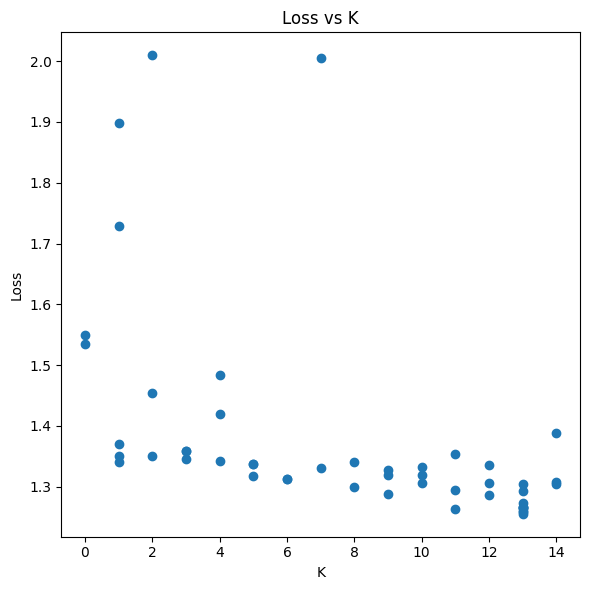

In [51]:

# Extract losses and hyperparameters
losses = [x['loss'] for x in trials.results]
hyperparams = [x['misc']['vals'] for x in trials.trials]

# Convert hyperparameter indices to actual values if necessary
# For example, for 'K' and 'epochs':
K_vals = [x['K'][0] for x in hyperparams]
epochs_vals = [x['epochs'][0] + 10 for x in hyperparams]  # +10 because the range starts from 10

# Plotting
plt.figure(figsize=(6, 6))

# # Plot loss vs K
# plt.subplot(1, 3, 1)
plt.scatter(K_vals, losses, marker = 'o')
plt.xlabel('K')
plt.ylabel('Loss')
plt.title('Loss vs K')
plt.tight_layout()
plt.show()


# Examing error

In [21]:

# Calculate the full user-item rating matrix
predicted_ratings = np.dot(P, Q)

predicted_ratings_df = pd.DataFrame(predicted_ratings)

# Now, rename the index to user_ids using the user_index_to_id mapping
predicted_ratings_df.rename(index=user_index_to_id, inplace=True)

# Rename the columns to item_ids using the item_index_to_id mapping
predicted_ratings_df.rename(columns=item_index_to_id, inplace=True)

predicted_ratings_df

,--onnLZrsCazmcy2P_7fcw,-3AooxIkg38UyUdlz5oXdw,-8iATYRnN46Km0_-ldx6cg,-9r8nAzWyRSLxBWt8uQOdA,-ALqLSTzkGDMscHdxA1NgA,-BdYhP-12elmFV7oB1iv4A,-FM4CxOg4XXmX_Ebky_SiQ,-FRHYI6doGCjIsXiKHkUqw,-Fka99c-tJ-epWYNIobqyQ,-H-fZonTLitwHFY_PLAIjA,...,zVxDd79gdZcfz-O14QBCrA,zWwGjQlUEiLS7hCXDkBGzg,zYTQOpgMSMaFNkcCAvJR3Q,zZrDoiQIUmiVkifJx0h_KA,zbrIMldF_O1ZQ0vpUaaa8A,zeAfmYy9b1gfUJLRBHm6vQ,ziXR7sUrbKRCNeDqfjibUg,zpuFEeAhrNzXPkOlBf5Kog,zu4p6IZLSVn2Noto-vcwzw,zxW8zECvT_SqejieMMjb5A
-0-TtVhV4PIUoDpUCOC0uQ,4.416289,3.220123,4.032065,3.790938,4.158561,4.652744,4.108342,3.034409,4.230828,3.882825,...,4.315915,4.345577,4.117470,4.847166,3.664895,3.699175,3.541297,3.060094,3.730689,5.224809
-0EcgtUXe1rzrkmdih_tYg,4.195013,3.110411,3.798564,3.050849,3.110614,4.383946,3.791624,2.263394,4.016559,3.618239,...,3.605556,3.936725,3.307656,3.923675,3.476933,3.526315,3.740782,2.489995,3.283749,4.891189
-1-ECBsGpG4Iw5s-ecnfqw,4.241842,3.956796,4.804674,4.016379,3.940337,5.017387,4.465880,2.842052,4.233984,4.475255,...,4.339039,4.639693,4.066645,4.553686,3.795671,4.131275,4.450937,2.487833,4.036211,5.629311
-14MA777BbjUQLw0zndvfA,3.182853,2.807122,3.934106,2.927928,3.347685,4.518578,3.645040,2.924386,3.040124,3.367171,...,4.049848,3.372365,3.235165,4.346189,3.447700,3.597470,3.172206,3.081470,2.708418,4.571183
-1WbN1Qd-opw8u3uEqs2Kg,3.708823,3.135376,4.032815,3.491248,3.985986,4.293024,3.788878,2.760092,3.555904,3.772552,...,4.029781,4.282683,3.576854,3.819654,3.455350,4.093845,3.444543,2.458059,3.620588,4.691287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuPjUmHmYz1TIiamDjgJgg,3.992606,3.140956,3.651629,3.381915,3.789726,4.388828,3.863601,2.497746,4.417918,3.436597,...,4.332865,3.953977,3.553479,4.213453,3.619668,3.878683,3.332820,3.306996,2.905060,4.420828
zv6CI7HvLGRHgu6yqX-Asw,3.810002,3.194179,4.390978,3.456974,3.905424,4.535366,3.874221,2.177239,3.615172,3.765860,...,4.059768,3.827894,3.435334,3.891558,3.417955,3.671062,3.832239,2.447803,3.737424,5.224240
zvs6DYpACuh0cpsPDO48dw,3.323210,2.916619,3.466217,2.952083,3.412540,3.646863,3.217893,2.483482,2.684779,2.935426,...,3.347675,2.804102,3.332209,2.933424,2.711918,2.706549,2.662075,2.489974,2.910742,3.895739
zxAM0cdIbZZYN-6gVQuntQ,3.566568,3.301426,3.823188,3.076942,3.754423,4.433272,3.646133,2.484724,3.110733,3.320262,...,3.924634,3.790582,3.109119,3.332383,3.193570,3.795225,3.268580,2.813958,2.993932,4.436575


In [23]:
#actual_df = pd.read_csv('test_data_n5.csv', index_col='user_id')

actual_df = pd.read_csv('../data/test_data_n5_r.csv')

# Now, rename the index to user_ids using the user_index_to_id mapping
actual_df.rename(index=user_index_to_id, inplace=True)


actual_df

,0,1,2,3,4,5,6,7,8,9,...,1143,1144,1145,1146,1147,1148,1149,1150,1151,1152
-0-TtVhV4PIUoDpUCOC0uQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-0EcgtUXe1rzrkmdih_tYg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1-ECBsGpG4Iw5s-ecnfqw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-14MA777BbjUQLw0zndvfA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1WbN1Qd-opw8u3uEqs2Kg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuPjUmHmYz1TIiamDjgJgg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zv6CI7HvLGRHgu6yqX-Asw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zvs6DYpACuh0cpsPDO48dw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zxAM0cdIbZZYN-6gVQuntQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
import numpy as np

# Find the indices of the non-NaN values
non_nan_indices = np.argwhere(~np.isnan(actual_df.values))

errors = []
for (i, j) in non_nan_indices:
    actual_value = actual_df.iloc[i, j]
    predicted_value = predicted_ratings_df.iloc[i, j]
    error = actual_value - predicted_value
    errors.append(error)



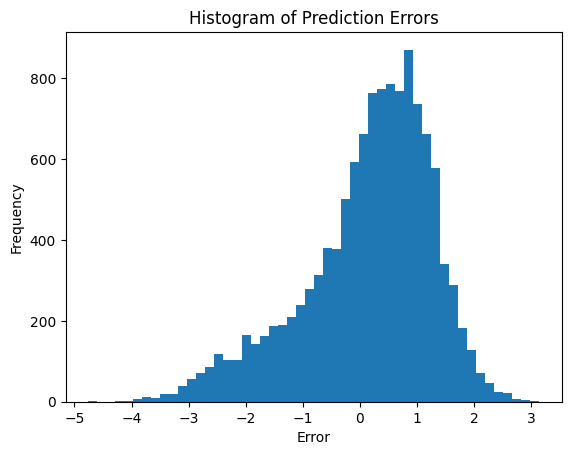

In [27]:
plt.hist(errors, bins=50)  # You can adjust the number of bins as needed
plt.title("Histogram of Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


### Observations: the model appears to be biased towards overly optimistic predictions, as the mode is around 1. Nevertheless, with an average MSE of around 1 star, the model is decent at predicting a user's ratings of a restaurant on average.